In [16]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import scipy.stats as st
import pandas as pd

In [3]:
h_scale = .70
c = 2.99792458e5
w = -1

class shared:
    kind = 'cubic'
    n = 2000
    
    step = .001
    zbegin = .01
    zfinal = 1.4
    n_interp = int((zfinal - zbegin) / step)

In [4]:
class Brandenberger:
    """Calculates τ, t_c, h, a, z, and ℜ in the Brandenberger model"""
    
    a0 = 1.0               # Current scale factor value
    h0 = 17150             # h = H/H0 initial value

    sec_to_yr = 3600.0 * 24.0 * 365.0
    
    def __init__(self, Ωm, hscale, E, t_cB, h_sol, a_solB, zB, ℜ, dLBspl, dLBinterp):
        self.Ωm        = Ωm
        self.hscale    = hscale
        self.E         = E 
        self.t_cB      = t_cB
        self.h_sol     = h_sol
        self.a_solB    = a_solB
        self.zB        = zB
        self.ℜ        = ℜ
        self.dLBspl    = dLBspl
        self.dLBinterp = dLBinterp
    
    
    def solve_h(self, h, t):
        """Differential equation that gives h(τ) as a solution"""
        return ((-3.0/2.0)*h**2.0 + (3.0/2.0)*np.cos(.5*self.E*t)**2.0)
    
    
    def dL_Brandenberger(self):
        """Calculates the luminosity distance dL in the Brandenberger model. 
        Returns a spline of dL and some interpolated values from the spline (used in plotting)"""
        
        def a_spl_Brandenberger(t_cB, a_solB, kind):
            """Splines cosmic time and scale factor; used in integral of dL"""
            a_splB  = interp1d(t_cB, a_solB, kind)
            return a_splB
        
        H0 = 100*self.hscale*3.2407792700054e-20*self.sec_to_yr
        
        integrand = lambda x : 1.0/(a_splB(x))
        
        a_splB  = a_spl_Brandenberger(self.t_cB, self.a_solB, shared.kind)
        
        self.dLB = [(1.0 + self.zB[i])*H0*integrate.quad(integrand, 
                                                         self.t_cB[i], 
                                                         self.t_cB[shared.n - 1])[0] for i in range(shared.n)]
        
        self.dLBspl = interp1d(self.zB, self.dLB, shared.kind)
            
        for i in range(shared.n):
            val = np.linspace(shared.zbegin, shared.zfinal, shared.n, endpoint = True)
            self.dLBinterp[i] = self.dLBspl(val[i])
        
        return self.dLBspl, self.dLBinterp
    
    
    def run_Brandenberger(self):
        """Calculates the essential parameters in the Brandenberger model"""
        
        def solve_a(a, t):
            """Differential equation for solving for a(t_c)"""
            return a*h_spl(t)
        
        def z_to_h(z):
            """Function that, given a redshift value, returns h; converts z to a and then interpolates h using a"""
            a = 1.0/(1.0 + z)
            return a_h_spl(a)
        
        
        ℜ_int = lambda z : 1.0/z_to_h(z)
        
        
        H0 = 100*self.hscale*3.2407792700054e-20*self.sec_to_yr
        
        τ0 = 379000*H0
        τf = 1
        stepB = τf / shared.n
        τ = np.arange(τ0, τf + τ0, stepB)
        
        for i in range(shared.n): self.t_cB[i] = τ[i]/H0
            
            
        t_bw  = np.flipud(self.t_cB)

        h_integ = odeint(self.solve_h, self.h0, τ)[..., 0]
        self.h_sol = h_integ*H0

        h_spl = interp1d(self.t_cB, self.h_sol, shared.kind, fill_value='extrapolate')
        

        a_solbw = odeint(solve_a, self.a0, t_bw)[..., 0]
        self.a_solB = np.flipud(a_solbw)


        for i in range(shared.n): self.zB[i] = (1.0/self.a_solB[i]) - 1.0

            
        a_h_spl = interp1d(self.a_solB, self.h_sol, shared.kind)

        
        z_r = 1000.0
        
        self.ℜ  = np.sqrt(self.Ωm)*H0*integrate.quad(ℜ_int, 0, z_r)[0]
        
        return self.h_sol, self.t_cB, self.a_solB, self.zB, self.ℜ

In [5]:
class ΛCDM:
    """Calulates z and dL in ΛCDM"""
    Ωb = 0                     # Baryonic    density parameter
    Ωm = .3                    # Dark matter density parameter
    Ωr = 0                     # Radiation   density parameter
    ΩΛ = 1.0 - Ωb - Ωm - Ωr    # Dark energy density parameter
    
    z_start = 1.401
    z_end = .001
    n  = 2000
    
    def __init__(self, zΛCDM, dLΛspl, dLEmpspl, dLVacspl, dLΛinterp, dLEmpinterp, dLVacinterp):
        self.zΛCDM = zΛCDM
        
        self.dLΛspl = dLΛspl
        self.dLEmpspl = dLEmpspl
        self.dLVacspl = dLVacspl
        
        self.dLΛinterp = dLΛinterp
        self.dLEmpinterp = dLEmpinterp
        self.dLVacinterp = dLVacinterp
        
    def get_H(self, x): return np.sqrt((self.Ωb + self.Ωm)*x**-3.0 
                                       + self.Ωr*x**-4.0 + self.ΩΛ*x**(-3.0*(1.0 + w)))
    
    def dL_ΛCDM(self):
        
        integrandΛCDM = lambda x : 1.0/(x**2.0 * self.get_H(x))
        
        dLΛCDM   = [(1.0 + self.zΛCDM[i])
                    *integrate.quad(integrandΛCDM, 1.0/(1.0 + self.zΛCDM[i]), 1)[0] for i in range(shared.n)]
        
        dLempty  = [(self.zΛCDM[i] + (self.zΛCDM[i]**2.0)/2.0) for i in range(shared.n)]
        
        dLvac    = [(self.zΛCDM[i] + self.zΛCDM[i]**2.0) for i in range(shared.n)]
        
        self.dLΛspl = interp1d(self.zΛCDM, dLΛCDM, shared.kind)
        self.dLEmpspl = interp1d(self.zΛCDM, dLempty, shared.kind)
        self.dLVacspl = interp1d(self.zΛCDM, dLvac, shared.kind)
        
        for i in range(shared.n):
            val = self.zΛCDM[i]
            
            self.dLΛinterp[i] = self.dLΛspl(val)
            self.dLEmpinterp[i] = self.dLEmpspl(val)
            self.dLVacinterp[i] = self.dLVacspl(val)
        
        return self.dLΛspl, self.dLEmpspl, self.dLVacspl, self.dLΛinterp, self.dLEmpinterp, self.dLVacinterp
    
    def calc_zΛCDM(self):
        
        self.zΛCDM = np.linspace(shared.zbegin, shared.zfinal, shared.n, endpoint=True)
        
        return self.zΛCDM
    

In [6]:
smplx = [1, 2, 3, 4]
smply = [1, 2, 3, 4]
ini_spl = interp1d(smplx, smply, kind = shared.kind)

n_ΔE = 29
lowE = .01
highE = 2
ΔE = np.linspace(lowE, highE, n_ΔE + 1, endpoint = True)
print(ΔE)

Ωmlow = .235
Ωmhigh = .283
nΩm = 100#10
Ωm = np.linspace(Ωmlow, Ωmhigh, nΩm, endpoint = True)
print(Ωm)

nH0 = 2
H0low = .65
H0high = .77
hscale = [.7]
print(hscale)

heatΩmE = np.ndarray(((n_ΔE + 1), len(Ωm), len(hscale),), dtype = np.object)

for i in range(n_ΔE + 1):
    print('ΔE[%s] = %.3f' % (i, ΔE[i]))
    for j in range(len(Ωm)):
        #print('|-->Ωm[%s] = %.3f' % (j, Ωm[j]))
        for k in range(len(hscale)):
            #print('|######>h[%s] = %.3f' % (k, hscale[k]))
            heatΩmE[i][j][k] = Brandenberger(Ωm[j], hscale[k], ΔE[i], t_cB = np.zeros(shared.n), h_sol = np.zeros(shared.n), a_solB = np.zeros(shared.n), zB = np.zeros(shared.n), ℜ = 1, dLBspl = ini_spl, dLBinterp = np.zeros(shared.n))
            heatΩmE[i][j][k].run_Brandenberger()
            # DO NOT USE THIS LINE!!! #heatΩmE[i][j][k].dL_Brandenberger()
    print('--------------------')
#print(heatΩmE)
print(' -- done with heat map -- ')

[0.01       0.07862069 0.14724138 0.21586207 0.28448276 0.35310345
 0.42172414 0.49034483 0.55896552 0.62758621 0.6962069  0.76482759
 0.83344828 0.90206897 0.97068966 1.03931034 1.10793103 1.17655172
 1.24517241 1.3137931  1.38241379 1.45103448 1.51965517 1.58827586
 1.65689655 1.72551724 1.79413793 1.86275862 1.93137931 2.        ]
[0.235      0.23548485 0.2359697  0.23645455 0.23693939 0.23742424
 0.23790909 0.23839394 0.23887879 0.23936364 0.23984848 0.24033333
 0.24081818 0.24130303 0.24178788 0.24227273 0.24275758 0.24324242
 0.24372727 0.24421212 0.24469697 0.24518182 0.24566667 0.24615152
 0.24663636 0.24712121 0.24760606 0.24809091 0.24857576 0.24906061
 0.24954545 0.2500303  0.25051515 0.251      0.25148485 0.2519697
 0.25245455 0.25293939 0.25342424 0.25390909 0.25439394 0.25487879
 0.25536364 0.25584848 0.25633333 0.25681818 0.25730303 0.25778788
 0.25827273 0.25875758 0.25924242 0.25972727 0.26021212 0.26069697
 0.26118182 0.26166667 0.26215152 0.26263636 0.26312121 0.2636

In [7]:
for i in range(len(ΔE)):
    
    print('ΔE[%s] = %.3f' % (i, ΔE[i]))
    
    heatΩmE[i][0][0].dL_Brandenberger()
    
print(' -- done with all instances of ΔE dL -- ')

ΔE[0] = 0.010
ΔE[1] = 0.079
ΔE[2] = 0.147
ΔE[3] = 0.216
ΔE[4] = 0.284
ΔE[5] = 0.353
ΔE[6] = 0.422
ΔE[7] = 0.490
ΔE[8] = 0.559
ΔE[9] = 0.628
ΔE[10] = 0.696
ΔE[11] = 0.765
ΔE[12] = 0.833
ΔE[13] = 0.902
ΔE[14] = 0.971
ΔE[15] = 1.039
ΔE[16] = 1.108
ΔE[17] = 1.177
ΔE[18] = 1.245
ΔE[19] = 1.314
ΔE[20] = 1.382
ΔE[21] = 1.451
ΔE[22] = 1.520
ΔE[23] = 1.588
ΔE[24] = 1.657
ΔE[25] = 1.726
ΔE[26] = 1.794
ΔE[27] = 1.863
ΔE[28] = 1.931
ΔE[29] = 2.000
 -- done with all instances of ΔE dL -- 


In [8]:
heatplt = np.ndarray(((n_ΔE + 1), len(Ωm), len(hscale),), dtype = np.longdouble).reshape((len(hscale), len(Ωm), (n_ΔE + 1)))

for i in range(len(hscale)):
    for j in range(len(Ωm)):
        for k in range(n_ΔE + 1):
            heatplt[i][j][k] = heatΩmE[k][j][i].ℜ

print(' -- done -- ')

 -- done -- 


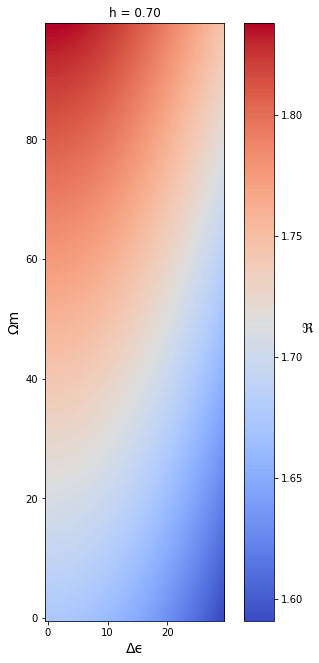

In [9]:
# i = h; j = Ωm; k = ΔE
xgridE = np.zeros(1)
ygridΩ = np.zeros(1)

def get_labels(narr):
    
    ticks = []
    
    for i in range(len(narr)):
        if i % 2 == 0:
            ticks.append(narr[i])
        else:
            ticks.append('')
            
    return ticks

bestdiff = 1000
bestj = 0
bestk = 0

for i in range(len(hscale)):
    plt.figure(figsize = (7, 11))
    plt.title('h = %.2f' % (hscale[i]))
    plt.xlabel('Δϵ', fontsize = 14)
    plt.ylabel('Ωm', fontsize = 14)
    
    fheatplt = plt.imshow(heatplt[i][:][:], cmap = 'coolwarm', interpolation = 'spline16')#,  vmin = 1.68, vmax = 1.74)
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    cb = plt.colorbar(fheatplt)
    cb.set_label('ℜ', fontsize = 14, rotation = 360)
    
    for j in range(len(Ωm)):
        for k in range(len(ΔE)):
            if ((heatplt[i][j][k] <= 1.74) and (heatplt[i][j][k] >= 1.68)):
                diff = abs(heatplt[i][j][k] - 1.71)
                if bestdiff > diff:
                    bestdiff = diff
                    bestj = j
                    bestk = k
                    
plt.show()

In [11]:
# Creates the object associated with ΛCDM values (and empty and vacuum dominated universes)
instCDM = ΛCDM(zΛCDM=np.zeros(shared.n), dLΛspl = ini_spl, dLEmpspl=ini_spl, dLVacspl=ini_spl, 
               dLΛinterp=np.zeros(shared.n), dLEmpinterp=np.zeros(shared.n), dLVacinterp=np.zeros(shared.n))

instCDM.calc_zΛCDM()
instCDM.dL_ΛCDM()

intR = lambda z : 1.0/math.sqrt(instCDM.Ωm*(1.0 + z)**3.0 + instCDM.ΩΛ)
cdmR = math.sqrt(instCDM.Ωm)*integrate.quad(intR, 0, 1000)[0]

print('ℜ = ', cdmR)
print(' -- done with ΛCDM -- ')

ℜ =  1.7470506313960619
 -- done with ΛCDM -- 


In [13]:
# Opens binned distance modulus supernova data

sn_raw_mod = []
n_rows_mod = 0

with open('jla_likelihood_v6\data\jla_mub.txt', 'r') as reader:
    for line in reader:
        sn_raw_mod.append(line)
        n_rows_mod += 1
        
col_num = 2
s = (n_rows_mod - 1, col_num)
sn_data_mod = np.zeros(s)
zb_mod = np.zeros(n_rows_mod - 1)
μb_mod = np.zeros(n_rows_mod - 1)

for i in range(1, n_rows_mod):
    split = sn_raw_mod[i].split()
    for j in range(col_num):
        sn_data_mod[i - 1][j] = split[j]
        zb_mod[i - 1] = split[0]
        μb_mod[i - 1] = split[1]

print(' -- done loading binned table -- ')

 -- done loading binned table -- 


 -- done resizing -- 
True
 -- done symmetrizing / transposing C matrix -- 


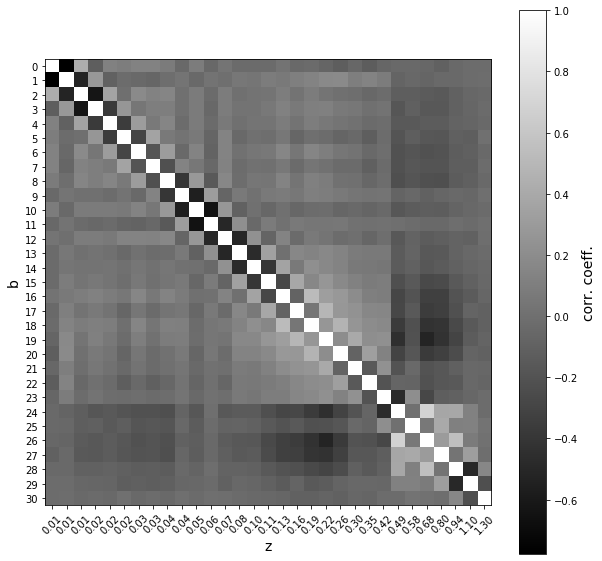

In [17]:
# Creates the convariant matrix of the binned distance modulus and its inverse

def res(d_array): return np.concatenate( (np.zeros(dim_row - len(d_array)), d_array), axis = None )

dim_row = 31

C = np.array([
              res([21282, -10840, 1918, 451, 946, 614, 785, 686, 581, 233, 881, 133, 475, 295, 277, 282, 412, 293, 337, 278, 219, 297, 156, 235, 133, 179, -25, -106,   0, 137, 168]),
              res([28155,  -2217, 1702,  74, 322, 380, 273, 424, 487, 266, 303, 406, 468, 447, 398, 464, 403, 455, 468, 417, 444, 351, 399,  83, 167, -86,  15,   -2,  76, 243]),
              res([ 6162,  -1593, 1463, 419, 715, 580, 664, 465, 613, 268, 570, 376, 405, 352, 456, 340, 412, 355, 317, 341, 242, 289, 119, 152, -69, -33, -44,   37, 209]),
              res([ 5235,   -722,  776, 588, 591, 583, 403, 651, 212, 555, 353, 355, 323, 442, 319, 372, 337, 288, 343, 210, 272,  92, 167, -48, -29, -21,  50,  229]),
              res([ 7303,   -508, 1026, 514, 596, 315, 621, 247, 493, 320, 375, 290, 383, 286, 350, 300, 269, 313, 198, 251,  99, 126,  18,  46,  13,  10, 203]),
              res([ 3150,   -249,  800, 431, 358, 414, 173, 514, 231, 248, 221, 293, 187, 245, 198, 175, 231, 126, 210, 103, 170,  51,  66,  -8, -51, 308]),
              res([ 3729,    -88,  730, 321, 592, 188, 546, 316, 342, 290, 389, 267, 341, 285, 252, 301, 189, 242, 122, 159,  35,  72,  30,  28, 255]),
              res([ 3222,   -143,  568, 421, 203, 491, 257, 280, 240, 301, 221, 275, 227, 210, 249, 148, 220, 123, 160,  43,  69,  27,   7, 253]),
              res([ 3225,   -508,  774, 156, 502, 273, 323, 276, 370, 260, 316, 273, 231, 273, 171, 226, 111, 154,   0,  29,  19,  23, 206]),
              res([ 5646,  -1735,  691, 295, 362, 316, 305, 370, 280, 346, 313, 276, 310, 217, 274, 131, 175,  38, 118,  78,  48, 303]),
              res([ 8630,  -1642,  944, 152, 253, 184, 274, 202, 254, 233, 196, 237, 156, 207,  27, 115, -32,   7, -15,   0, 176]),
              res([ 3855,   -754,  502, 225, 278, 294, 274, 285, 253, 239, 255, 173, 229, 181, 177,  93, 124, 132, 108, 227]),
              res([ 4340,   -634,  660, 240, 411, 256, 326, 276, 235, 290, 184, 256, 135, 222,  90, 152,  67,  17, 318]),
              res([ 2986,   -514,  479, 340, 363, 377, 362, 315, 343, 265, 311, 144, 198,  17,  62,  86, 147, 226]),
              res([ 3592,   -134,  606, 333, 422, 374, 333, 349, 267, 300, 157, 184,   9,  71,  85, 136, 202]),
              res([ 1401,     22,  431, 343, 349, 302, 322, 245, 284, 171, 186,  70,  70,  93, 142, 202]),
              res([ 1491,    141,  506, 386, 356, 394, 278, 306, 188, 212,  79,  71, 106, 145, 240]),
              res([ 1203,    200,  435, 331, 379, 281, 311, 184, 209,  49,  51, 110, 197, 181]),
              res([ 1032,    258,  408, 398, 305, 330, 197, 223,  78,  79, 113, 174, 225]),
              res([ 1086,    232,  453, 298, 328, 120, 189, -48,  22,  42, 142, 204]),
              res([ 1006,    151,  329, 282, 169, 195,  58,  80,  95, 192, 188]),
              res([ 1541,    124,  400, 199, 261, 150, 166, 202, 251, 251]),
              res([ 1127,     72,  227, 222,  93, 118,  93, 171, 161]),
              res([ 1723,   -105,  406,  -3, 180, 190, 198, 247]),
              res([ 1550,    144,  946, 502, 647, 437, 215]),
              res([ 1292,    187,  524, 393, 387, 284]),
              res([ 3941,    587, 1657, 641, 346]),
              res([ 2980,    360, 1124, 305]),
              res([ 4465,  -1891,  713]),
              res([23902,  -1826]),
              res([19169])
            ])

C = 1.0e-6 * C

print(' -- done resizing -- ')

for i in range(1, dim_row):
    if i == 1:
        C[1][0] = C[0][1]
    else:
        for j in range(i):
            C[i][j] = C[j][i]
            
C_inv = np.linalg.inv(C)
            
print(np.allclose(np.dot(C_inv, C), np.eye(31)))


print(' -- done symmetrizing / transposing C matrix -- ')

# The distance modulus error bars are the square roots of the diagonal
err = [np.sqrt(C[i][i]) for i in range(dim_row)]


plt.figure(figsize=(10, 10))
dataset = pd.DataFrame(data=C)
corr = dataset.corr()
plt.xticks(ticks = np.arange(len(zb_mod)), labels=[('%.2f' % zb_mod[k]) for k in range(len(zb_mod))], rotation = 45)
plt.yticks(ticks = np.arange(len(μb_mod)), labels=[j for j in range(len(μb_mod))])
cm = plt.imshow(corr, cmap='gray', interpolation='nearest')
cb = plt.colorbar(cm)
cb.set_label('corr. coeff.', fontsize=14)
plt.xlabel('z', fontsize=14)
plt.ylabel('b', fontsize=14)
plt.show()

ΔE = 0.010 || M = 0.15916  || χ2 = 47.29865
ΔE = 0.079 || M = 0.15916  || χ2 = 47.19355
ΔE = 0.147 || M = 0.15816  || χ2 = 46.93002
ΔE = 0.216 || M = 0.15616  || χ2 = 46.51159
ΔE = 0.284 || M = 0.15315  || χ2 = 45.94466
ΔE = 0.353 || M = 0.14915  || χ2 = 45.24087
ΔE = 0.422 || M = 0.14515  || χ2 = 44.41371
ΔE = 0.490 || M = 0.14014  || χ2 = 43.47822
ΔE = 0.559 || M = 0.13413  || χ2 = 42.45243
ΔE = 0.628 || M = 0.12713  || χ2 = 41.35737
ΔE = 0.696 || M = 0.12012  || χ2 = 40.21961
ΔE = 0.765 || M = 0.11211  || χ2 = 39.06352
ΔE = 0.833 || M = 0.10310  || χ2 = 37.91725
ΔE = 0.902 || M = 0.09309  || χ2 = 36.81346
ΔE = 0.971 || M = 0.08308  || χ2 = 35.78435
ΔE = 1.039 || M = 0.07207  || χ2 = 34.86589
ΔE = 1.108 || M = 0.06106 || χ2 = 34.09269
ΔE = 1.177 || M = 0.04905 || χ2 = 33.50468
ΔE = 1.245 || M = 0.03704 || χ2 = 33.14014
ΔE = 1.314 || M = 0.02402 || χ2 = 33.03832
ΔE = 1.382 || M = 0.01001 || χ2 = 33.23925
ΔE = 1.451 || M = -0.00400 || χ2 = 33.78121
ΔE = 1.520 || M = -0.01802 || χ2 = 34

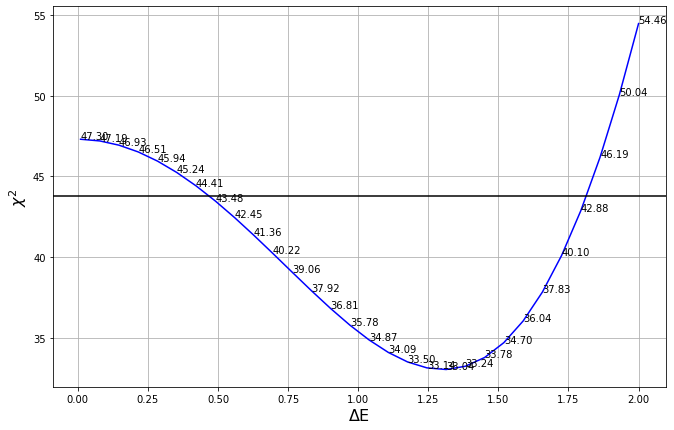

In [18]:
h0 = 100.0*h_scale
convert = c/h0*1.0e6/10.0

def find_M(zb_mod, μb_frm, dL_mat, C_inv):
    
    grid_size = 1000
    χmin_fine_low  = np.zeros(grid_size)
    χmin_fine_high = np.zeros(grid_size)
    
    st = 0
    nd = 1
    
    mmin_fine_low  = np.linspace(st, -nd, num=grid_size, endpoint=True)
    mmin_fine_high = np.linspace(st,  nd, num=grid_size, endpoint=True)
    
    new_m = np.zeros((dim_row, 1))
    
    for j in range(grid_size):
        fine_m = new_m + mmin_fine_low[j]
            
        r_mat = μb_frm - fine_m - dL_mat
        r_dagger_mat = np.transpose(r_mat)
        χmin_fine_low[j] = np.matmul(r_dagger_mat, np.matmul(C_inv, r_mat))
        
        fine_m = new_m + mmin_fine_high[j]
        
        r_mat = μb_frm - fine_m - dL_mat
        r_dagger_mat = np.transpose(r_mat)
        χmin_fine_high[j] = np.matmul(r_dagger_mat, np.matmul(C_inv, r_mat))
        
    χlow_fine = min(χmin_fine_low)
    χhigh_fine = min(χmin_fine_high)
    
    if χlow_fine < χhigh_fine:
        mindex = np.argmin(χmin_fine_low)
        return χlow_fine, mmin_fine_low[mindex]
    elif χhigh_fine < χlow_fine:
        mindex = np.argmin(χmin_fine_high)
        return χhigh_fine, mmin_fine_high[mindex]
    else:
        mindex = np.argmin(χmin_fine_low)
        return χlow_fine, mmin_fine_low[mindex]
    

def χsq_calc(zb_mod, μb_mod, dLtheory, C_inv):
    
    dL_mat = np.zeros((dim_row, 1))
    μb_frm = np.zeros((dim_row, 1))
    
    for i in range(dim_row):
        dL_mat[i] = 5.0*np.log(dLtheory(zb_mod[i])*convert)/np.log(10.0)
        μb_frm[i] = μb_mod[i]
    
    χ2, mmin = find_M(zb_mod, μb_frm, dL_mat, C_inv)   

    return χ2, mmin


def get_model(ind, χsq):
    if ind < len(ΔE):
        return 'ΔE min = %.2f at index %s' % (ΔE[index_min], ind)
    elif ind == len(ΔE):
        return 'ΛCDM, Ωm = %.2f with χ2 = %.2f' % (ΛCDM.Ωm, χsq[ind])
    elif ind == (len(ΔE) + 1):
        return 'an empty universe'
    elif ind == (len(ΔE) + 2):
        return 'a vacuum dominated universe'
    
    
χsq   = np.zeros(len(ΔE) + 3)
M_min = np.zeros(len(ΔE) + 3)


for i in range(len(χsq)):
    if i < len(ΔE):
        #χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, inst[i].dLBspl, C_inv)
        χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, heatΩmE[i][0][0].dLBspl, C_inv)
        if i <= len(ΔE)/2.0:
            print('ΔE = %.3f || M = %.5f  || χ2 = %.5f' % (ΔE[i], M_min[i], χsq[i]))
        else:
            print('ΔE = %.3f || M = %.5f || χ2 = %.5f' % (ΔE[i], M_min[i], χsq[i]))
    elif i == len(ΔE):
        χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dLΛspl, C_inv)
        print('ΛCDM       || M = %.5f  || χ2 = %.5f' % (M_min[i], χsq[i]))
    elif i == (len(ΔE) + 1):
        χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dLEmpspl, C_inv)
        print('Empty      || M = %.5f  || χ2 = %.5f' % (M_min[i], χsq[i]))
    elif i == (len(ΔE) + 2):
        χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dLVacspl, C_inv)
        print('Vacuum     || M = %.5f || χ2 = %.5f' % (M_min[i], χsq[i]))
        
        
print('\n')
print('χ2:', χsq)
print('\n')
print('Min of χ2: %.5f' % min(χsq))
print('Min of ΔE χ2: %.5f' % min(χsq[0:len(ΔE)]))
index_min = np.argmin(χsq[:])
index_min_Bb = np.argmin(χsq[0:len(ΔE)])
print('This corresponds to', get_model(index_min, χsq))
print('\n')


signifInd = np.zeros(1)
signifE = np.zeros(1)
setInd = True
print(' ----- Significant models for dof = 30, p<= .05 ----- ')
for i in range(len(ΔE) + 3):
    if χsq[i] <= 43.773:
        
        if i < len(ΔE):
            χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, heatΩmE[i][0][0].dLBspl, C_inv)
            if (setInd):
                signifInd[0] = i
                signifE[0] = ΔE[i]
                setInd = False
            else:
                signifInd = np.append(signifInd, i)
                signifE = np.append(signifE, ΔE[i])
                
            if i <= len(ΔE)/2.0:
                print('ΔE = %.3f || M = %.5f  || χ2 = %.5f' % (ΔE[i], M_min[i], χsq[i]))
            else:
                print('ΔE = %.3f || M = %.5f || χ2 = %.5f' % (ΔE[i], M_min[i], χsq[i]))
        elif i == len(ΔE):
            χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dLΛspl, C_inv)
            print('ΛCDM       || M = %.5f  || χ2 = %.5f' % (M_min[i], χsq[i]))
        elif i == (len(ΔE) + 1):
            χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dLEmpspl, C_inv)
            print('Empty      || M = %.5f  || χ2 = %.5f' % (M_min[i], χsq[i]))
        elif i == (len(ΔE) + 2):
            χsq[i], M_min[i] = χsq_calc(zb_mod, μb_mod, instCDM.dLVacspl, C_inv)
            print('Vacuum     || M = %.5f || χ2 = %.5f' % (M_min[i], χsq[i]))

print('---------------------------------------------------')
print('significant indices:', signifInd)
print(signifE)

plt.figure(figsize = (11, 7))
plt.plot(ΔE, χsq[0:n_ΔE + 1], 'b')
for i, j in zip(ΔE, χsq[:]): plt.annotate('%.2f' % j, xy = (i, j), textcoords = 'data')
plt.xlabel('ΔE', fontsize = 16)
plt.ylabel('$χ^2$', fontsize = 16)
plt.axhline(y = 43.773, xmin = 0, xmax = 2, color = 'k')
plt.grid()
plt.show()

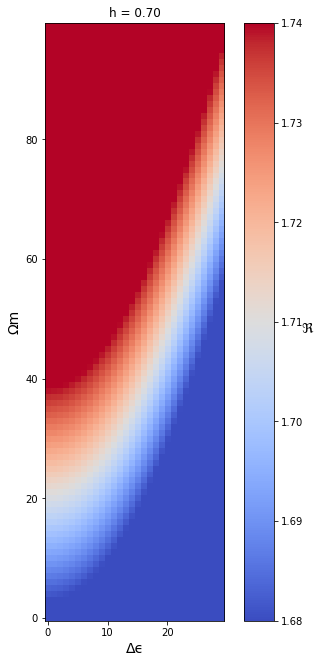

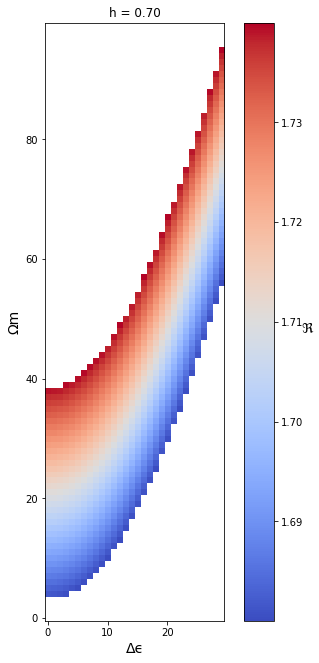

In [19]:
# i = h; j = Ωm; k = ΔE

xgridE = np.zeros(1)
ygridΩ = np.zeros(1)
zgridℜ = np.zeros(1)
statgrid = np.zeros((nΩm, len(ΔE)))
statgrid2 = np.zeros((nΩm, len(ΔE)))
for i in range(len(hscale)):
    plt.figure(figsize = (7, 11))
    plt.title('h = %.2f' % (hscale[i]))
    plt.xlabel('Δϵ', fontsize = 14)
    plt.ylabel('Ωm', fontsize = 14)
    #plt.xticks(ticks = np.arange(len(ΔE)), labels = [('%.4f' % ΔE[k]) for k in range(len(ΔE))], rotation = 45)
    #plt.yticks(ticks = np.arange(len(Ωm)), labels = [('%.4f' % Ωm[j]) for j in range(len(Ωm))])
    fheatplt = plt.imshow(heatplt[i][:][:], cmap = 'coolwarm', interpolation = 'nearest',  vmin = 1.68, vmax = 1.74)
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    cb = plt.colorbar(fheatplt)
    cb.set_label('ℜ', fontsize = 14, rotation = 360)
    
    for j in range(len(Ωm)):
        for k in range(len(ΔE)):
            if ((heatplt[i][j][k] <= 1.74) and (heatplt[i][j][k] >= 1.68)):
                statgrid[j][k] = heatplt[i][j][k]
                
plt.show()

mask = np.zeros_like(statgrid, dtype=bool)
mask2 = np.zeros_like(statgrid, dtype=bool)

plt.figure(figsize = (7, 11))
plt.title('h = %.2f' % (hscale[i]))
plt.xlabel('Δϵ', fontsize = 14)
plt.ylabel('Ωm', fontsize = 14)

for j in range(len(Ωm)):
    for k in range(len(ΔE)):
        
        if ((heatplt[0][j][k] > 1.74) or (heatplt[0][j][k] < 1.68)):
            mask[j, k] = True
            mask2[j, k] = True
        if k not in signifInd:
            mask2[j, k] = True
            
        if ((heatplt[0][j][k] < 1.74) and (heatplt[0][j][k] > 1.68)):
            diff = abs(heatplt[0][j][k] - 1.71)
            if bestdiff > diff:
                bestdiff = diff
                bestj = j
                bestk = k


statgrid = np.ma.array(statgrid, mask=mask)
statgrid2 = np.ma.array(statgrid2, mask=mask2)
corner_mask = False

fheatpltgrid = plt.imshow(statgrid, cmap='coolwarm', interpolation='nearest')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
cb = plt.colorbar(fheatpltgrid)
cb.set_label('ℜ', fontsize=14, rotation=360)
#plt.savefig('R-ELimit')
plt.show()

In [20]:
x, y = np.meshgrid(ΔE, Ωm)

mskplt = np.ndarray(((n_ΔE + 1), len(Ωm),), dtype = np.longdouble).reshape((len(Ωm), (n_ΔE + 1)))

for j in range(len(Ωm)):
    for k in range(len(ΔE)):      
        if ((heatplt[i][j][k] > 1.74) or (heatplt[i][j][k] < 1.68)):
            mskplt[j][k] = 0
        else:
            mskplt[j][k] = statgrid[j][k]

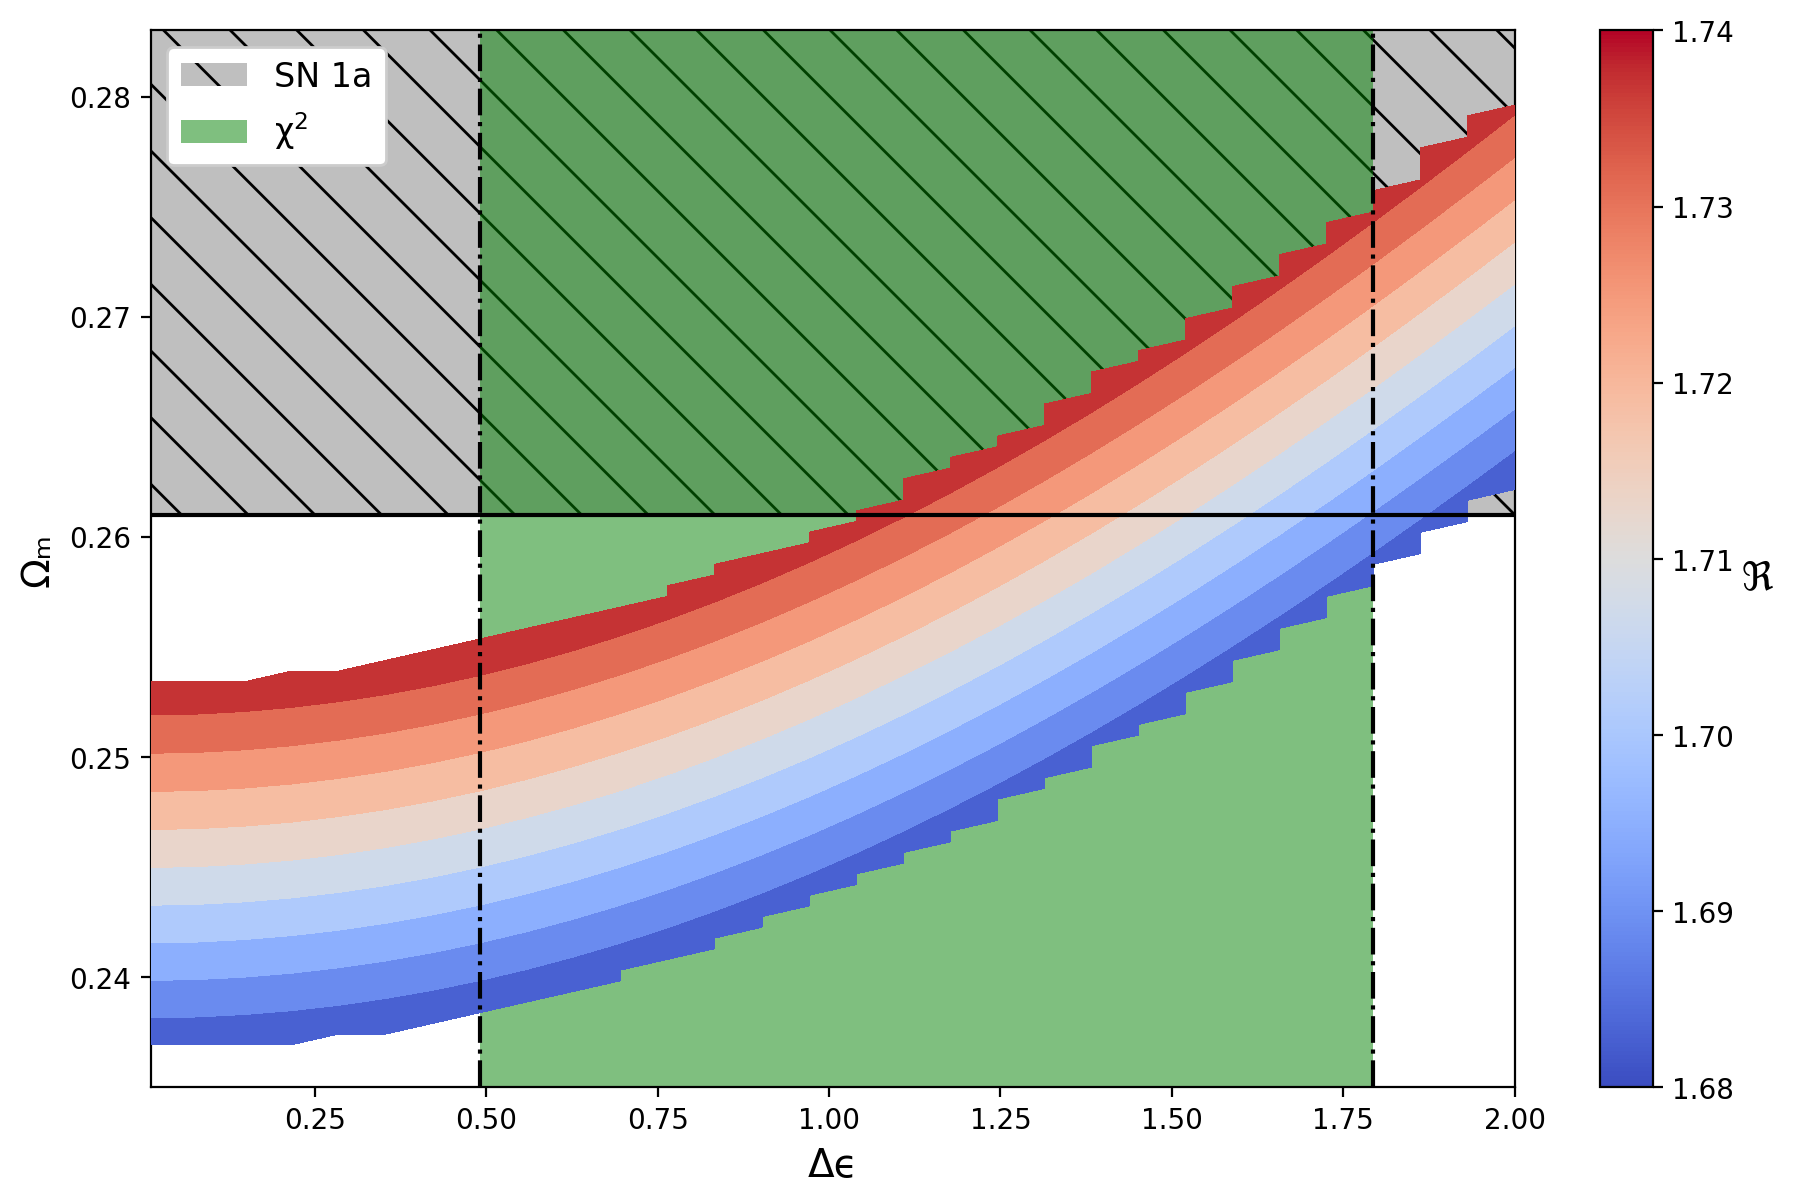

In [21]:
plt.figure(figsize = (11, 7), dpi = 200)

rectangle = plt.Rectangle((0, .261), 2, .034, fc = 'gray', alpha = .5, label = 'SN 1a', hatch = '\\', zorder = 2)#ec = 'black'
plt.gca().add_patch(rectangle)
plt.axhline(y = .261, xmin = 0, xmax = 2, ls = '-', color = 'k', zorder = 5)

rectangle2 = plt.Rectangle((ΔE[int(signifInd[0])], .235), (ΔE[int(signifInd[-1])] - ΔE[int(signifInd[0])]), (Ωm[-1] - Ωm[0]), fc = 'green', alpha = .5, label = 'χ$^2$', zorder = 2.5)# hatch = '/'
plt.gca().add_patch(rectangle2)
plt.axvline(x = ΔE[int(signifInd[0])], ls = '-.', color = 'k', zorder = 5.5)
plt.axvline(x = ΔE[int(signifInd[-1])], ls = '-.', color = 'k', zorder = 6)

plt.contourf(x, y, statgrid, 10, cmap = 'coolwarm', zorder = 3)

cb = plt.colorbar(fheatplt)
cb.set_label('  ℜ', fontsize = 14, rotation = 360)

plt.xlim(ΔE[0], ΔE[-1])
plt.ylim(Ωm[0], Ωm[-1])
plt.xlabel('Δϵ', fontsize = 14)
plt.ylabel('Ωₘ', fontsize = 14)
plt.legend(loc = 'upper left', framealpha = 1, prop = {'size': 12})
plt.savefig('R-para-space', dpi = 200)
plt.show()

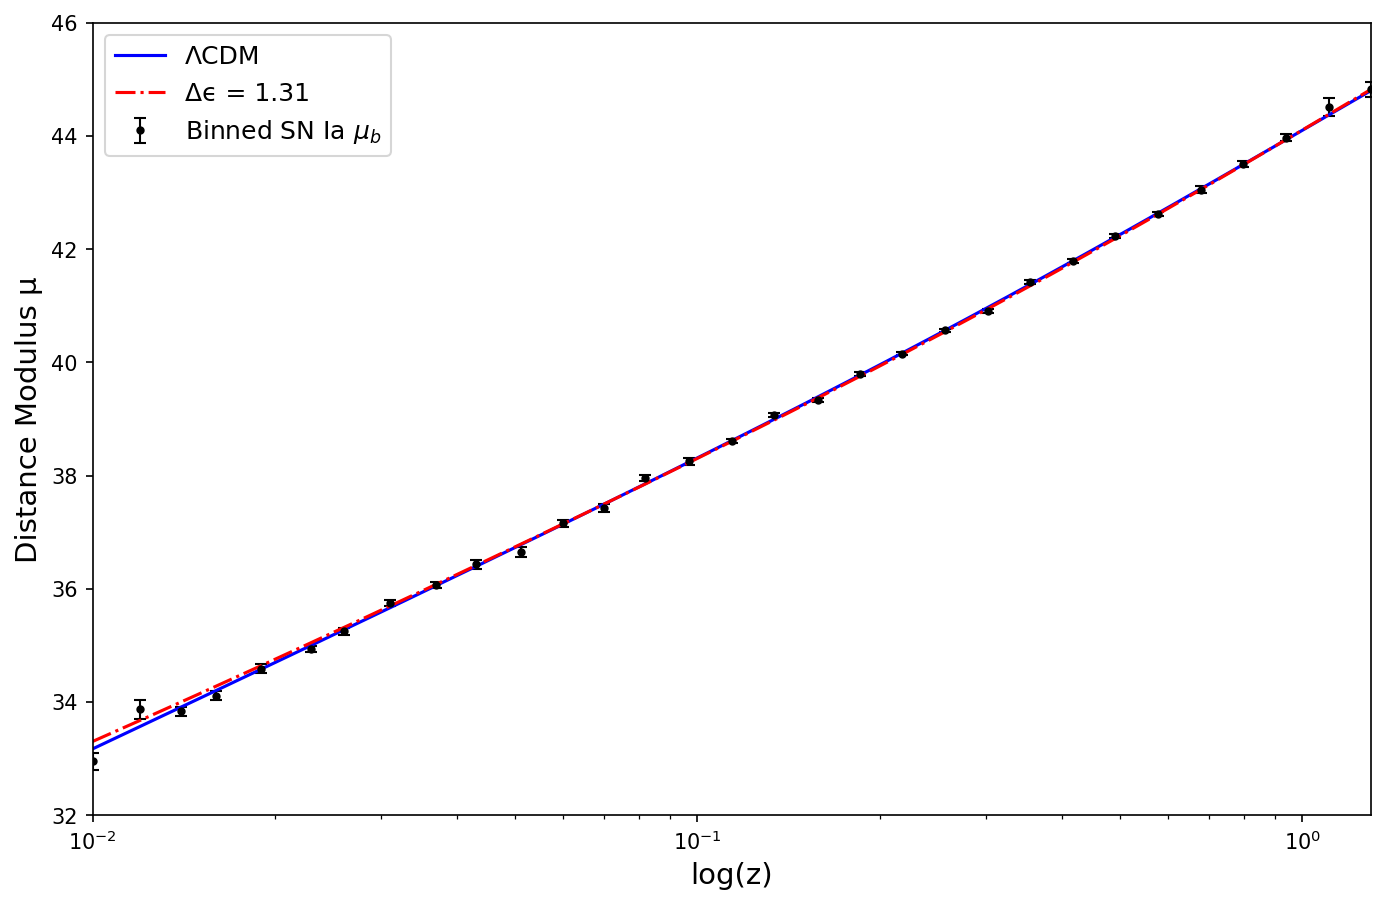

In [23]:
conv_dLB = np.zeros((n_ΔE + 1, shared.n))
plot_z = np.linspace(shared.zbegin, shared.zfinal, shared.n, endpoint = True)

for i in range(n_ΔE + 1):
    for j in range(1, shared.n):
        conv_dLB[i][j - 1] = 5.0 * np.log(heatΩmE[i][0][0].dLBinterp[j] * convert) / np.log(10.0)
        
#conv_dLV = np.zeros(shared.n)
#conv_dLE = np.zeros(shared.n)
conv_dLΛ = np.zeros(shared.n)
    
for i in range(shared.n):
    #conv_dLE[i] = 5.0 * np.log(instCDM.dLEmpinterp[i] * convert) / np.log(10.0)
    #conv_dLV[i] = 5.0 * np.log(instCDM.dLVacinterp[i] * convert) / np.log(10.0)
    conv_dLΛ[i] = 5.0 * np.log(instCDM.dLΛinterp[i]   * convert) / np.log(10.0)
    
plt.figure(figsize = (11, 7), dpi = 150)
plt.errorbar(zb_mod, μb_mod, yerr = err, capsize = 3, elinewidth = 1, color = 'k', fmt = '.', label = 'Binned SN Ia $μ_b$')

plt.plot(plot_z, conv_dLΛ,    'b', label = 'ΛCDM')#, $Ω_m$ = %.3f' % ΛCDM.Ωm)

plt.plot(plot_z, conv_dLB[index_min_Bb][:], 'r-.', label = ('Δϵ = %.2f' % heatΩmE[index_min_Bb][0][0].E))

plt.xlabel('log(z)', fontsize = 14)
plt.ylabel('Distance Modulus μ', fontsize = 14)
plt.xscale('log')
plt.xlim(.01, 1.3)
plt.ylim(32, 46)
plt.legend(loc = 'best', prop = {'size': 12})
#plt.savefig('dL_SN_01-1_no_grid', dpi = 150)
plt.show()

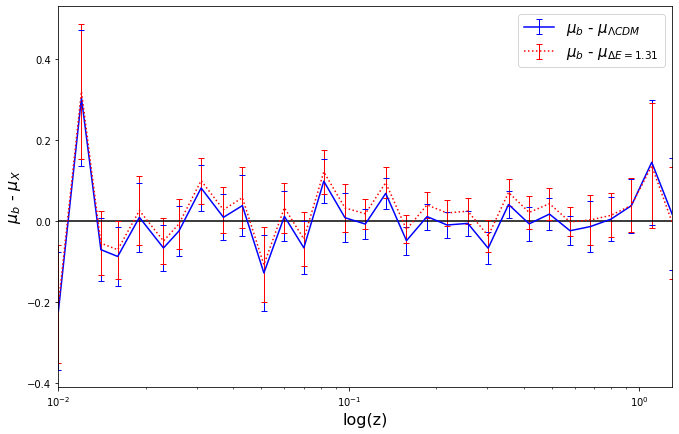

In [26]:
comp_CDM = [5.0 * np.log(instCDM.dLΛspl(zb_mod[i])*convert)
            /np.log(10.0) for i in range(len(μb_mod))]

comp_Bb = [5.0 * np.log(heatΩmE[index_min_Bb][0][0].dLBspl(zb_mod[j])*convert)
           /np.log(10.0) for j in range(len(μb_mod))]

plt.figure(figsize = (11, 7))

plt.plot(zb_mod, [comp_CDM[i] - comp_CDM[i] for i in range(len(comp_CDM))], color='k')

plt.errorbar(zb_mod, [μb_mod[i] - comp_CDM[i] for i in range(len(μb_mod))], 
             yerr=err, color='b', capsize=3, 
             elinewidth=1, label='$μ_b$ - $μ_{ΛCDM}$')

plt.errorbar(zb_mod, [μb_mod[i] - comp_Bb[i] for i in range(len(μb_mod))],  
             yerr=err, ls=':', color='r', capsize=3, elinewidth=1, 
             label=('$μ_b$ - $μ_{ΔE = %.2f}$' % heatΩmE[index_min_Bb][0][0].E))

plt.xscale('log')
plt.xlabel('log(z)', fontsize=16)
plt.ylabel('$μ_b$ - $μ_X$', fontsize=16)
plt.legend(loc='best', prop={'size': 15})
plt.xlim(.01, 1.3)
plt.show()